<a href="https://colab.research.google.com/github/LeoMaggio/DPS-AI-Engineer-Challenge/blob/main/Mission_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score

DATASET = 'https://opendata.muenchen.de/dataset/5e73a82b-7cfb-40cc-9b30-45fe5a3fa24e/resource/40094bd6-f82d-4979-949b-26c8dc00b9a7/download/220511_monatszahlenmonatszahlen2204_verkehrsunfaelle.csv'

# Data Preprocessing

 We download the dataset and drop the useless columns.

In [134]:
df = pd.read_csv(DATASET)

In [135]:
df.drop(['VORJAHRESWERT', 'VERAEND_VORMONAT_PROZENT', 'VERAEND_VORJAHRESMONAT_PROZENT', 'ZWOELF_MONATE_MITTELWERT'], inplace=True, axis=1)
df.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT
0,Alkoholunfälle,insgesamt,2022,202201,NaN
1,Alkoholunfälle,insgesamt,2022,202202,NaN
2,Alkoholunfälle,insgesamt,2022,202203,NaN
3,Alkoholunfälle,insgesamt,2022,202204,NaN
4,Alkoholunfälle,insgesamt,2022,202205,NaN


In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2086 entries, 0 to 2085
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MONATSZAHL   2086 non-null   object 
 1   AUSPRAEGUNG  2086 non-null   object 
 2   JAHR         2086 non-null   int64  
 3   MONAT        2086 non-null   object 
 4   WERT         2002 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 81.6+ KB


We extract the target row for which we want to predict the value.

In [137]:
target = df.loc[(df['MONAT']=='202201') & (df['MONATSZAHL']=='Alkoholunfälle') & (df['AUSPRAEGUNG']=='insgesamt')]
target['MONAT'] = target['MONAT'].str[4:]
target = target.drop(['WERT'], axis=1)
target

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT
0,Alkoholunfälle,insgesamt,2022,01


WERT column present null values we have to deal with. They refer to 2022.

In [138]:
df = df.dropna()

# Data Visualization

Definying a dataframe for the years.

In [139]:
df_summe = df[df['MONAT']=='Summe']
df_summe.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT
12,Alkoholunfälle,insgesamt,2021,Summe,383.0
25,Alkoholunfälle,insgesamt,2020,Summe,430.0
38,Alkoholunfälle,insgesamt,2019,Summe,434.0
51,Alkoholunfälle,insgesamt,2018,Summe,398.0
64,Alkoholunfälle,insgesamt,2017,Summe,409.0


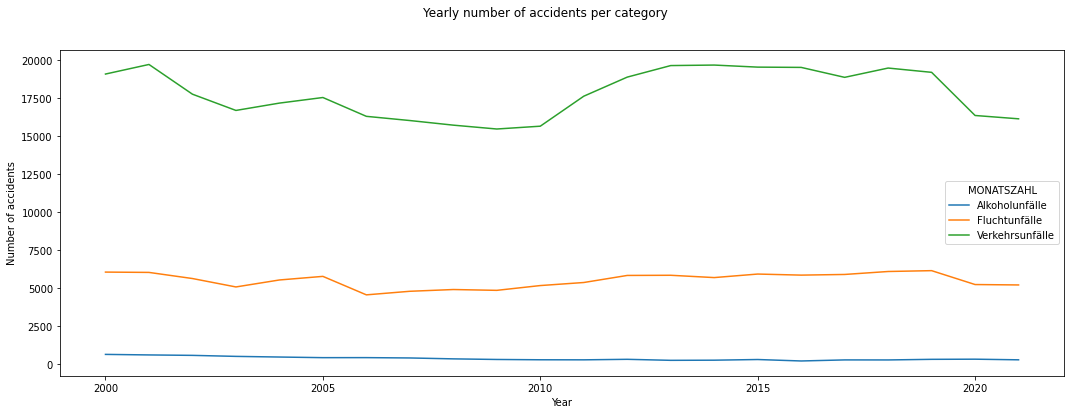

In [140]:
fig, ax = plt.subplots(figsize=(18,6))
df_summe.groupby(['JAHR', 'MONATSZAHL']).mean()['WERT'].unstack().plot(ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Number of accidents')
fig.suptitle('Yearly number of accidents per category')
fig.savefig('year.jpg')
plt.show()

Fixing the month column and definying a dataframe for months.

In [141]:
df_mon = df[df['MONAT']!='Summe']
df_mon['MONAT'] = df_mon['MONAT'].str[4:]
df_mon.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT
13,Alkoholunfälle,insgesamt,2021,01,16.0
14,Alkoholunfälle,insgesamt,2021,02,14.0
15,Alkoholunfälle,insgesamt,2021,03,24.0
16,Alkoholunfälle,insgesamt,2021,04,16.0
17,Alkoholunfälle,insgesamt,2021,05,24.0


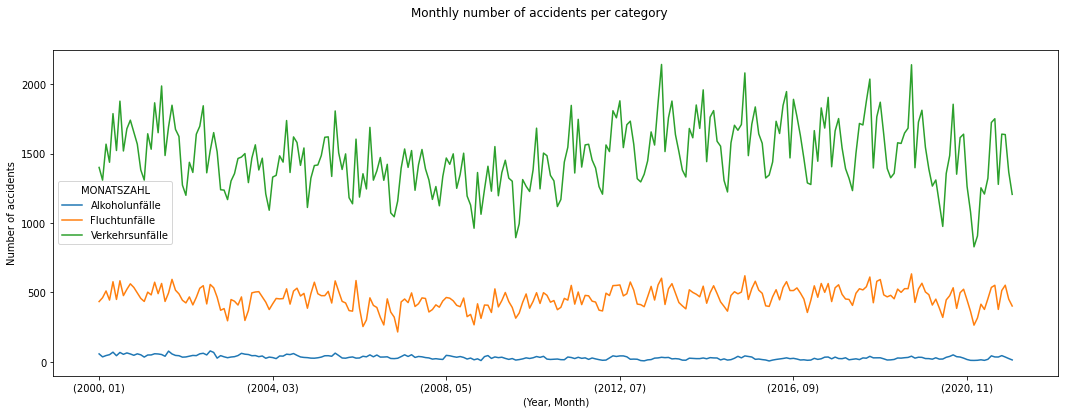

In [142]:
fig, ax = plt.subplots(figsize=(18,6))
df_mon.groupby(['JAHR', 'MONAT', 'MONATSZAHL']).mean()['WERT'].unstack().plot(ax=ax)
ax.set_xlabel('(Year, Month)')
ax.set_ylabel('Number of accidents')
fig.suptitle('Monthly number of accidents per category')
fig.savefig('month.jpg')
plt.show()

# Regression Model

Encoding categorical variables. The encoder is fitted on train data and transforms the target.

In [143]:
%%capture
label_encoder = preprocessing.LabelEncoder()
df_mon['MONATSZAHL'] = label_encoder.fit_transform(df_mon['MONATSZAHL'])
target['MONATSZAHL'] = label_encoder.transform(target['MONATSZAHL'])
df_mon['AUSPRAEGUNG'] = label_encoder.fit_transform(df_mon['AUSPRAEGUNG'])
target['AUSPRAEGUNG'] = label_encoder.transform(target['AUSPRAEGUNG'])

Generating a train set and a test set (2021) to find the best regression model.

In [144]:
X_train = df_mon[df_mon['JAHR']<2021]
Y_train = X_train['WERT']
X_train = X_train.drop(['WERT'], axis=1)

In [145]:
X_test = df_mon[df_mon['JAHR']>2020]
Y_test = X_test['WERT']
X_test = X_test.drop(['WERT'], axis=1)

In [146]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
Y_pred = lr.predict(X_test)
r2_score(Y_test, Y_pred)

0.2762588114643326

In [147]:
ridge = Ridge()
ridge.fit(X_train, Y_train)
Y_pred = ridge.predict(X_test)
r2_score(Y_test, Y_pred)

0.2763092933628145

In [148]:
svm = LinearSVR()
svm.fit(X_train, Y_train)
Y_pred = svm.predict(X_test)
r2_score(Y_test, Y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


-0.13195717919943006

In [149]:
rf = RandomForestRegressor()
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)
r2_score(Y_test, Y_pred)

0.9695562864610051

Random Forest Regressor performs the best based on R2 score, so we use it to make the prediction.

In [150]:
X = df_mon.drop(['WERT'], axis=1)
Y = df_mon['WERT']
rf.fit(X, Y)
prediction = rf.predict(target)
prediction[0]

17.2